<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/larissa_santesso/Aula_4_Exerc%C3%ADcio_Larissa_Santesso_%5BNew%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
len(dataset_train)

1000

In [7]:
x, y = dataset_train[0]
x.shape

torch.Size([1, 28, 28])

In [8]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class DataLoader:
    def __init__(self, x=x, batch_size=batch_size, shuffle=True):
        self.x = list(x)
        self.batch_size = batch_size

        # inicializando o index toda vez que chama a função
        self.index = 0

        # salvando o tamanho do dataloader antes de descompactar
        # (len(self.x) % self.batch_size > 0) será igual a 1 se houver algum resto na divisão
        self.length = len(self.x)//self.batch_size + (len(self.x) % self.batch_size > 0) 
        
        if shuffle==True:
            random.shuffle(self.x)

        # é preciso descompactar as listas para conseguir pegar x e y separadamente depois
        self.x = list(zip(*self.x)) 
        self.x[0] = torch.stack(self.x[0],dim=0)  
        self.x[1] = torch.tensor(self.x[1]).long()

    def __len__(self):
        return self.length

    def __iter__(self):
        #inicializando o index em zero toda vez que aplicar iter no dataloader
        self.index = 0
        return self

    def __next__(self): 
        # enquanto o index do dataloader for menor que o tamanho total dele mesmo
        # o item a ser retornado será o x e o y do batch relacionado àquele index
        if self.index < len(self):
            item1 = self.x[0][self.index*self.batch_size:self.index*self.batch_size+self.batch_size]
            item2 = self.x[1][self.index*self.batch_size:self.index*self.batch_size+self.batch_size]
            self.index += 1
            return item1,item2

        # se já percorreu todo o dataloader, irá parar a iteração.
        else:
            raise StopIteration

loader_train = DataLoader(dataset_train, batch_size=50, shuffle=False)

In [9]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [10]:
x_train.dtype, x_train.shape, y_train.dtype, y_train.shape

(torch.float32, torch.Size([50, 1, 28, 28]), torch.int64, torch.Size([50]))

## Modelo

In [11]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Model():
    def __init__(self, n_in: int, n_out: int):
        self.weights = torch.zeros(n_out,n_in, requires_grad=True)
        self.bias = torch.zeros(n_out, requires_grad=True)

    def __call__(self,x):    
        y_pred = x.mm(torch.t(self.weights))+self.bias.unsqueeze(0)
        return y_pred
    
    def parameters(self):
        return self.weights, self.bias

model = Model(28*28,10)

## Treinamento

### Inicialização dos parâmetros

In [12]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [13]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class CrossEntropyLoss:
    def __init__(self):
        self.loss = 0

    def __call__(self,outputs, targets):   
        exp_x = torch.exp(outputs)
        sum_x = torch.sum(exp_x, dim=1, keepdim=True)

        batch_size = outputs.shape[0]
        outputs = torch.log(exp_x/sum_x)
        outputs = outputs[range(batch_size), targets]

        return -torch.sum(outputs)/batch_size

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [14]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
    def __init__(self, parameters: tuple, learning_rate: float):
        self.parameters = parameters
        self.lr = learning_rate
        

    def step(self):
        for parameter in self.parameters:
            parameter.data = (parameter.data - self.lr * parameter.grad).detach()

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = torch.zeros_like(parameter.data) # ideia baseada do notebook de Pedro Gengo: torch.zeros_like

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [15]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    loader_train = DataLoader(dataset_train, batch_size=50, shuffle=False)
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786017417908
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270558834076
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632185459136963
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799142360687
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123182952404022
Epoch: 21/49 Loss: 0.30506113171577454
Epoch: 22/49 Loss: 0.29816243052482605
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/4

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

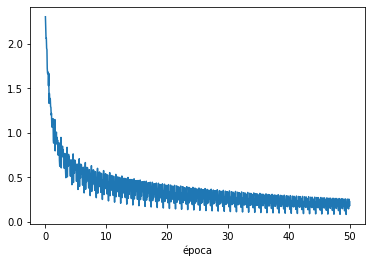

In [16]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

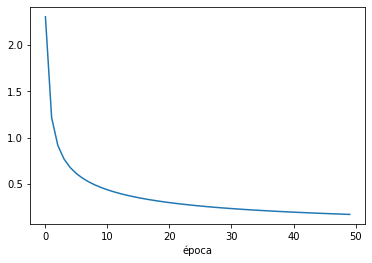

In [17]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [18]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [19]:
loader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False) 
# o loader_train terá  em um batch só todo o conjunto de treino

In [23]:
# Escreva o código aqui:

for x, y in loader_train:
    inputs = x.view(-1, 28 * 28)
    # predict da rede
    outputs = model(inputs)
    # calculando as probabilidades com softmax:
    exp_x = torch.exp(outputs)
    sum_x = torch.sum(exp_x, dim=1, keepdim=True)
    prob = (exp_x/sum_x).detach().numpy()

    # pred será um vetor contendo as classes com a probabilidade máxima, ou seja, as classes preditas pelo modelo
    pred = np.argmax(prob, axis = 1)

    
    correct = np.where(pred==y.numpy())[0]  # vetor contendo os index das amostras que foram classificadas corretamente
    wrong = np.where(pred!=y.numpy())[0] # vetor contendo os index das amostras que foram classificadas erradamente

    # Qual é a amostra classificada corretamente, com maior probabilidade?
    prob1 = np.argmax(prob[correct,pred[correct]]) 
    # prob1 será o index da amostra com a maior probabilidade do vetor: prob[[correct],y[correct]]
    # o index da amostra do conjunto todo será correct[prob1]
    print(f"Amostra classificada corretamente com maior probabilidade = \033[1m{correct[prob1]}\033[0m com probabilidade = \033[1m{prob[correct, y[correct]][prob1]}\033[0m")

    # Qual é a amostra classificada erradamente, com maior probabilidade?
    prob2 = np.argmax(prob[wrong,pred[wrong]])
    # prob2 será o index da amostra com a maior probabilidade do vetor: prob[wrong,y[wrong]]
    # o index da amostra do conjunto todo será wrong[prob2]
    print(f"Amostra classificada erradamente com maior probabilidade = \033[1m{wrong[prob2]}\033[0m com probabilidade = \033[1m{prob[wrong,y[wrong]][prob2]}\033[0m")

    # Qual é a amostra classificada corretamente, com menor probabilidade?
    prob3 = np.argmin(prob[correct,pred[correct]])
    # prob3 será o index da amostra com a menor probabilidade do vetor: prob[correct,y[correct]]
    # o index da amostra do conjunto todo será correct[prob3]
    print(f"Amostra classificada corretamente com menor probabilidade = \033[1m{correct[prob3]}\033[0m com probabilidade = \033[1m{prob[correct,y[correct]][prob3]}\033[0m")

    # Qual é a amostra classificada erradamente, com menor probabilidade?
    prob4 = np.argmin(prob[wrong,pred[wrong]])
    # prob4 será o index da amostra com a menor probabilidade do vetor: prob[wrong,y[wrong]]
    # o index da amostra do conjunto todo será wrong[prob4]
    print(f"Amostra classificada erradamente com menor probabilidade = \033[1m{wrong[prob4]}\033[0m com probabilidade = \033[1m{prob[wrong,y[wrong]][prob4]}\033[0m")

Amostra classificada corretamente com maior probabilidade = 183 com probabilidade = 0.9999896883964539
Amostra classificada erradamente com maior probabilidade = 271 com probabilidade = 0.09108582884073257
Amostra classificada corretamente com menor probabilidade = 532 com probabilidade = 0.33532676100730896
Amostra classificada erradamente com menor probabilidade = 68 com probabilidade = 0.039028704166412354


In [24]:
pred.shape, pred

((1000,),
 array([1, 3, 1, 8, 3, 4, 0, 0, 9, 5, 3, 3, 6, 4, 0, 8, 0, 8, 9, 6, 8, 1,
        6, 7, 9, 8, 2, 0, 8, 0, 7, 2, 2, 4, 0, 1, 3, 3, 9, 3, 3, 8, 0, 1,
        3, 7, 8, 3, 3, 9, 3, 8, 7, 7, 6, 2, 7, 6, 1, 0, 8, 4, 6, 6, 1, 6,
        1, 0, 8, 2, 7, 7, 3, 9, 1, 7, 1, 2, 7, 3, 2, 1, 0, 4, 0, 1, 6, 1,
        3, 7, 3, 1, 1, 0, 0, 7, 3, 1, 7, 2, 8, 4, 1, 2, 1, 3, 1, 3, 5, 6,
        2, 9, 3, 0, 4, 5, 0, 8, 9, 0, 0, 7, 4, 2, 3, 3, 4, 6, 3, 7, 7, 3,
        4, 9, 3, 0, 9, 7, 1, 0, 3, 5, 8, 8, 8, 8, 2, 7, 8, 4, 5, 8, 4, 8,
        3, 8, 2, 6, 9, 5, 8, 3, 7, 1, 2, 6, 7, 5, 7, 5, 7, 1, 8, 9, 2, 3,
        6, 9, 3, 1, 7, 8, 9, 2, 3, 6, 4, 7, 1, 4, 8, 9, 6, 5, 4, 6, 7, 0,
        4, 8, 6, 5, 1, 4, 3, 2, 4, 3, 5, 6, 9, 9, 5, 8, 7, 0, 1, 8, 2, 5,
        1, 3, 7, 9, 9, 5, 1, 7, 2, 1, 5, 9, 1, 4, 8, 8, 1, 8, 4, 7, 8, 2,
        3, 8, 5, 6, 3, 4, 7, 7, 1, 4, 4, 4, 5, 9, 1, 9, 1, 0, 5, 7, 0, 5,
        9, 1, 8, 5, 0, 4, 7, 8, 3, 8, 2, 3, 1, 2, 8, 9, 7, 9, 1, 7, 0, 3,
        0, 4, 0, 3, 5, 2, 9,

In [25]:
correct.shape, correct

((967,),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178,

In [26]:
wrong.shape, wrong

((33,), array([ 38,  68, 150, 182, 193, 212, 220, 225, 237, 244, 271, 279, 334,
        339, 409, 440, 467, 560, 583, 609, 672, 723, 729, 761, 810, 831,
        834, 855, 873, 931, 944, 967, 982]))

In [27]:
prob[correct,y[correct]].shape, prob[correct,y[correct]]

((967,), array([0.9556815 , 0.9437638 , 0.9907506 , 0.91281337, 0.94140095,
        0.9247087 , 0.9991128 , 0.8893706 , 0.932841  , 0.62552017,
        0.9364046 , 0.8816171 , 0.87165105, 0.9674332 , 0.8877755 ,
        0.9288944 , 0.88816005, 0.9275219 , 0.97737813, 0.8250302 ,
        0.67874867, 0.9214793 , 0.9969046 , 0.47126502, 0.75969607,
        0.9045347 , 0.9999024 , 0.9930889 , 0.53266937, 0.75404215,
        0.9517636 , 0.9854048 , 0.58600724, 0.8872376 , 0.99044436,
        0.97453314, 0.5718511 , 0.9898625 , 0.8783435 , 0.97429407,
        0.47435933, 0.8700171 , 0.9864552 , 0.90719056, 0.9763088 ,
        0.9962824 , 0.8228521 , 0.7937413 , 0.9983301 , 0.8223848 ,
        0.93989974, 0.78980505, 0.9833053 , 0.9878377 , 0.9793798 ,
        0.94534624, 0.9701688 , 0.95370364, 0.99310005, 0.958023  ,
        0.5489822 , 0.98804724, 0.9884925 , 0.9719826 , 0.79259896,
        0.99126375, 0.79610366, 0.99982125, 0.67364115, 0.9868437 ,
        0.9353028 , 0.98467535, 0.945159

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


In [ ]:
# Em desenvolvimento